In [2]:
import csv
import pandas as pd
import numpy as np

In [114]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.cluster import KMeans

In [17]:
def col_sparsity(df, col):
    return df[col].isna().sum()/df.shape[0]

In [215]:
accepted = pd.read_csv("Data/Lending_Club_Accepted_2014_2018.csv")
rejected = pd.read_csv("Data/Lending_Club_Rejected_2014_2018.csv")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [495]:
spot_3yr = pd.read_csv("Data/usgg3yr.csv")
spot_5yr = pd.read_csv("Data/usgg5yr.csv")

In [476]:
spot_5yr["Date"].dtype

dtype('O')

In [496]:
spot_3yr["Date"] = [datetime.strptime(row['Date'],'%m/%d/%Y') for index, row in spot_3yr.iterrows()]
spot_5yr["Date"] = [datetime.strptime(row['Date'],'%m/%d/%Y') for index, row in spot_5yr.iterrows()]

In [492]:
spot_3yr["Date"].min()

Timestamp('2013-12-31 00:00:00')

In [431]:
accepted = accepted_all.sample(frac=0.01)
#rejected = rejected.sample(frac=0.001)

In [48]:
col_sparsity(accepted, "total_il_high_credit_limit")

0.0

In [51]:
list(accepted.columns).index("home_ownership")

12

In [29]:
from operator import itemgetter


In [93]:
def risk_imputed_df(df, risk_columns):
    ## Removing very sparse columns from the beginning
    risk_columns = risk_columns[col_sparsity(df, risk_columns) < 0.01]
    dfr = df[risk_columns]
    imp = IterativeImputer(max_iter = 5, random_state = 0, verbose = 0)
    imp.fit(dfr)
    dfr_imputed_arr = imp.transform(dfr)
    dfr_imputed = pd.DataFrame(dfr_imputed_arr, columns = dfr.columns)
    return dfr_imputed, imp
    

In [226]:
def risk_score_embedding(df, n_components = 3):
    ## Obtain risk history columns
    risk_columns = ['annual_inc', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']
    risk_columns = np.array(risk_columns)
    
    ##Imputation and sparse column removal
    dfr, imp = risk_imputed_df(df, risk_columns)
    
    ##Defining scaler and PCA
    scaler = StandardScaler()
    pca = PCA(n_components = n_components)
    
    ##Standard Scaler Transform
    df_a_t = scaler.fit_transform(dfr)
    
    ##PCA Transform
    df_a_pca = pca.fit_transform(df_a_t)
    
    ## Assigning Risk PCA's to dataframe
    df["Risk_PCA_1"] = [arr[0] for arr in df_a_pca]
    df["Risk_PCA_2"] = [arr[1] for arr in df_a_pca]
    df["Risk_PCA_3"] = [arr[2] for arr in df_a_pca]
    
    return df, pca, imp

In [136]:
def cluster_on_risk_score_embedding(df, num_clusters = 4):
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans = kmeans.fit(df[["Risk_PCA_1","Risk_PCA_2","Risk_PCA_3"]])
    df["Risk_Cluster"] = kmeans.labels_
    return df

In [142]:
def average_interest_rate_by_cluster(df, num_clusters = 4):
    for cluster in range(0,num_clusters):
        df_c = df.loc[df["Risk_Cluster"]==cluster]
        print(f"RC{cluster} Avg IR: ",df_c["int_rate"].median())


Metrics to use for return:

- installment: monthly payment owed by borrower if loan originates
- issue_d: month which the loan was funded
- loan_status: Fully Paid, Current, Charged Off, In Grace Period, Late (16-30 days), Late (31-120 days)
- out_prncp: Remaining outstanding principal for total amount funded
- total_pymnt: Payments received to date for total amount funded
- total_pymnt_inv: Payments received to date for portion of total amount funded by investors
- total_rec_prncp: Principal received to date
- total_rec_int: Interest received to date
- total_rec_late_fee: Late fees received to date
- recoveries: post charge-off gross recoveries
- collection_recovery_fee: post charge-off collection fee
- last_pymnt_d: last month payment was received
- last_pymnt_amt: last total payment amount received
- next_pymnd_d: next scheduled payment date
- last_credit_pull_d: most recent month LC pulled credit for this loan
- ALL SETTLMENT INFO (see last page of metrics)

Model: Does a risk cluster's change in average performance (returns or failure) at time t predict the risk cluster's interest rate assignment after time t?

Given a lag amount L and a risk cluster C, can we fit

IR(C, t) = beta * (IR(C, t-L), AR(C, t-L), AR(C, t-L-1), ...)

In [163]:
accepted_n = accepted[["next_pymnt_d","loan_status"]].dropna()
accepted_n.loc[accepted_n["loan_status"]=="Charged Off"]

,next_pymnt_d,loan_status


In [183]:
from datetime import datetime
from dateutil import relativedelta


In [185]:
def date_diff_months(date1, date2):
    fulldelta = relativedelta.relativedelta(date1, date2)
    return fulldelta.years * 12 + fulldelta.months

In [191]:
def issue_date_datetime(df):
    df['issue_d'] = [datetime.strptime(row['issue_d'],'%b-%Y') for index, row in df.iterrows()]
    return df

In [258]:
def date_as_datetime(df, col):
    df[col] = [datetime.strptime(row[col],'%b-%Y') for index, row in df.iterrows()]
    return df

In [231]:
def issue_date_numerical(df):
    min_date = df['issue_d'].min()
    df['month_diff_issue_d'] = df.apply(lambda x: date_diff_months(x['issue_d'],min_date), axis = 1)
    return df

In [520]:
def duration_encoded(df):
    df['term_encoded'] = df.apply(lambda x: int(x['term'][1:3]), axis = 1)
    return df

In [238]:
accepted, em1, em2 = risk_score_embedding(accepted)
accepted = issue_date_datetime(accepted)
accepted = issue_date_numerical(accepted)
accepted = duration_encoded(accepted)

In [244]:
def end_date_inserted(df):
    df['end_date'] = df.apply(lambda x: x['issue_d'] + pd.DateOffset(months = x['term']), axis = 1)
    return df

In [253]:
def prepaid_boolean(df):
    df['prepaid'] = df.apply(lambda x: x['loan_status']=='Fully Paid' and x['last_pymnt_d'] < x['end_date'], axis = 1)
    return df

In [302]:
def performance_added(df):
    df["perf"] = df.apply(lambda x: int(x["loan_status"] not in ["Late (31-120 days)","Late (Late (16-30 days))","Charged Off"]), axis = 1)
    return df

In [335]:
def groupby_rearr(df):
    df_n = df[["issue_d","Risk_Cluster","int_rate","perf"]]
    df_n = df_n.groupby(["issue_d","Risk_Cluster"], as_index = False).mean()
    return df_n

In [336]:
accepted_n = performance_added(accepted)

In [337]:
accepted_n = accepted_n.loc[accepted_n["loan_status"] != "Current"]

In [338]:
accepted_n = groupby_rearr(accepted_n)

In [339]:
accepted_n.loc[accepted_n["Risk_Cluster"] == 0]

,issue_d,Risk_Cluster,int_rate,perf
0,2014-01-01,0,12.927213,0.852459
3,2014-02-01,0,13.468333,0.770833
6,2014-03-01,0,13.927797,0.813559
9,2014-04-01,0,13.076087,0.855072
12,2014-05-01,0,13.392388,0.776119
15,2014-06-01,0,13.209254,0.791045
18,2014-07-01,0,12.636505,0.825243
21,2014-08-01,0,12.221857,0.842857
24,2014-09-01,0,12.243830,0.808511
27,2014-10-01,0,12.719514,0.875000


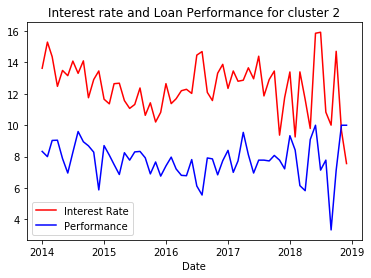

In [348]:
RISK_CLUSTER = 2
accepted_n_0 = accepted_n.loc[accepted_n["Risk_Cluster"]==RISK_CLUSTER]
plt.plot(accepted_n_0['issue_d'], accepted_n_0['int_rate'], color = 'r', label = 'Interest Rate')
plt.plot(accepted_n_0['issue_d'],accepted_n_0['perf']*10, color = 'b', label = 'Performance')
plt.legend()
plt.title(f"Interest rate and Loan Performance for cluster {RISK_CLUSTER}")
plt.xlabel("Date")
plt.show()

In [383]:
def back_window_moving_average(df, column, t, k1, k2, time_column):
    df_out = df.copy()
    df_out['in_range'] = df_out.apply(lambda x: x[time_column] < t - relativedelta.relativedelta(months = k1)
                                     and x[time_column] > t - relativedelta.relativedelta(months=k2), axis =1)
    df_out = df_out.loc[df_out['in_range']==True]
    if df_out.empty:
        return None
    return df_out[column].mean()

In [558]:
def moving_avg_diff(df, target_column, k1, k2, k3, t, time_column):
    if t - relativedelta.relativedelta(months=k3) < df[time_column].min():
        return None
    elif back_window_moving_average(df, target_column, t, k1, k2, time_column) is None or \
    back_window_moving_average(df, target_column, t, k1, k3, time_column) is None:
        return None
    
    return back_window_moving_average(df, target_column, t, k1, k2, time_column)-\
                                    back_window_moving_average(df, target_column, t, k1, k3, time_column)
                                    

In [376]:
def window_added(df, target_column, k1, k2, k3, time_column):
    df[f"moving_avg_diff_{target_column}"] = df.apply(lambda x: moving_avg_diff(df, target_column, k1, k2, k3,
                                                              x[time_column],time_column), axis = 1)
    return df

In [381]:
def ma_added(df, target_column, k, time_column):
    df_out = df.copy()
    df_out[f"moving_avg_{target_column}"] = df_out.apply(lambda x: back_window_moving_average(df_out, target_column,x['issue_d'],0,k,time_column), axis = 1)
    return 

In [403]:
def diff_ma(df):
    df['ir_diff_ma'] = df['int_rate']-df['moving_avg_int_rate']
    return df

In [394]:
accepted_n_0_ma = window_added(accepted_n_0, 'perf', 5,7,9,'issue_d')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [397]:
accepted_n_0_ma = ma_added(accepted_n_0_ma, 'int_rate',3,'issue_d')

In [407]:
from scipy.stats import pearsonr
accepted_n_0_ma_pearson = accepted_n_0_ma[["ir_diff_ma","moving_avg_diff_perf"]].dropna()
pearsonr(accepted_n_0_ma_pearson['ir_diff_ma'],accepted_n_0_ma_pearson['moving_avg_diff_perf'])

(-0.049720703977992387, 0.7289756262680054)

In [497]:
def get_spot(date, years = 3):
    if years == 5:
        spot_5yr.loc[spot_5yr["Date"]==date]["PX_LAST"].mean()
    return spot_3yr.loc[spot_3yr["Date"]==date]["PX_LAST"].mean()

In [502]:
accepted = accepted_all.sample(frac=0.001)
accepted = issue_date_datetime(accepted)
accepted = duration_encoded(accepted)
#print(accepted.iloc[0]['term']/12)
get_spot(accepted.iloc[0]['issue_d'],accepted.iloc[0]['term']/12)

1.4619

In [548]:
def prep_for_test(accepted, N_COMPONENTS, N_CLUSTERS):
    accepted = duration_encoded(accepted)
    accepted["int_rate"] = accepted.apply(lambda x: get_spot(x['issue_d'],x['term_encoded']/12),axis = 1)
    accepted, em1, em2 = risk_score_embedding(accepted, n_components = N_COMPONENTS)
    accepted = cluster_on_risk_score_embedding(accepted, num_clusters = N_CLUSTERS)
    accepted = issue_date_datetime(accepted)
    
    #print(accepted.head())
    accepted = duration_encoded(accepted)
    #print(accepted.head())
    accepted_n = performance_added(accepted)
    #print(accepted_n.head())
    accepted_n = groupby_rearr(accepted_n)
    return accepted_n
    
def test_p_val(accepted_n, k1, k2, k3):
    p_vals = []
    r_vals = []
    for count in range(N_CLUSTERS):
        accepted_n_c = accepted_n.loc[accepted_n["Risk_Cluster"]==count]
        accepted_n_c = window_added(accepted_n_c, 'perf', k1,k2,k3,'issue_d')
        accepted_n_c = ma_added(accepted_n_c, 'int_rate',3,'issue_d')
        accepted_n_c = diff_ma(accepted_n_c)
        accepted_n_c = accepted_n_c[["ir_diff_ma","moving_avg_diff_perf"]].dropna()
        r, pval = pearsonr(accepted_n_c['ir_diff_ma'],accepted_n_c['moving_avg_diff_perf'])
        p_vals.append(pval)
        r_vals.append(r)
    return np.mean(np.array(p_vals)), np.mean(r_vals)

In [562]:
accepted = accepted_all.sample(frac=0.001)
accepted_n = prep_for_test(accepted,4,10)

In [547]:
accepted['issue_d']

1910995    Oct-2017
702938     May-2016
76065      Nov-2015
1756061    Aug-2016
796189     Aug-2018
1481342    Jun-2018
1190508    Sep-2014
799123     Aug-2018
1935535    Dec-2016
154228     Sep-2015
1546379    May-2018
198604     Aug-2015
377875     Feb-2015
1167414    Oct-2014
1135395    Nov-2014
72647      Nov-2015
585950     Aug-2017
1496995    Jun-2018
1908448    Oct-2017
1715604    Sep-2016
432956     Mar-2018
1196665    Sep-2014
910903     Jun-2017
1712338    Sep-2016
699022     May-2016
1937561    Dec-2016
1207505    Aug-2014
2026305    Oct-2016
453731     Mar-2018
1469321    Oct-2018
             ...   
268145     Jun-2015
1804417    Jul-2016
367313     Feb-2015
1256553    Jun-2014
551065     Sep-2017
826983     Aug-2018
1004252    Mar-2016
319712     May-2015
171153     Aug-2015
340074     Mar-2015
754169     Sep-2018
760437     Sep-2018
153740     Sep-2015
102304     Oct-2015
1285568    May-2014
588140     Aug-2017
1232479    Jul-2014
1993512    Nov-2016
1507748    Jun-2018


In [557]:
accepted_n

,issue_d,Risk_Cluster,int_rate,perf
0,2014-01-01,0,0.7645,1.000000
1,2014-01-01,1,0.7645,0.750000
2,2014-01-01,3,0.7645,1.000000
3,2014-01-01,4,0.7645,1.000000
4,2014-01-01,5,0.7645,1.000000
5,2014-01-01,9,0.7645,1.000000
6,2014-02-01,0,NaN,0.000000
7,2014-02-01,1,NaN,1.000000
8,2014-02-01,3,NaN,1.000000
9,2014-02-01,4,NaN,1.000000


In [569]:
min_pval = 1
best_config = None
for k1 in range(20,30):
    for k2 in range(k1+2, 30):
        for k3 in range(k2+2, 30):
            #print(k1,k2,k3)
            tpv = test_p_val(accepted_n, k1, k2, k3)[0]
            if  tpv < min_pval:
                min_pval = tpv
                best_config = [k1,k2,k3]
                
print(min_pval)
print(best_config)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.2234660866616405
[24, 27, 29]


In [568]:
min_pval

0.10284787218791146